In [1]:
from gibbs.dataclass import GibbsResult,get_results
import numpy as np
from gibbs.utils import simple_purify_hamiltonian,printarray,spectral_dec,candidate
import matplotlib.pyplot as plt
from gibbs.learning.bayesian_learning_v2 import BayesianLearning
from gibbs.learning.constraint_matrix import ConstraintMatrixFactory
from gibbs.plots.plots import compare_preparations, axis_locality,preparation
import plotly.express as px
from qiskit.quantum_info import state_fidelity

%load_ext autoreload
%autoreload 2

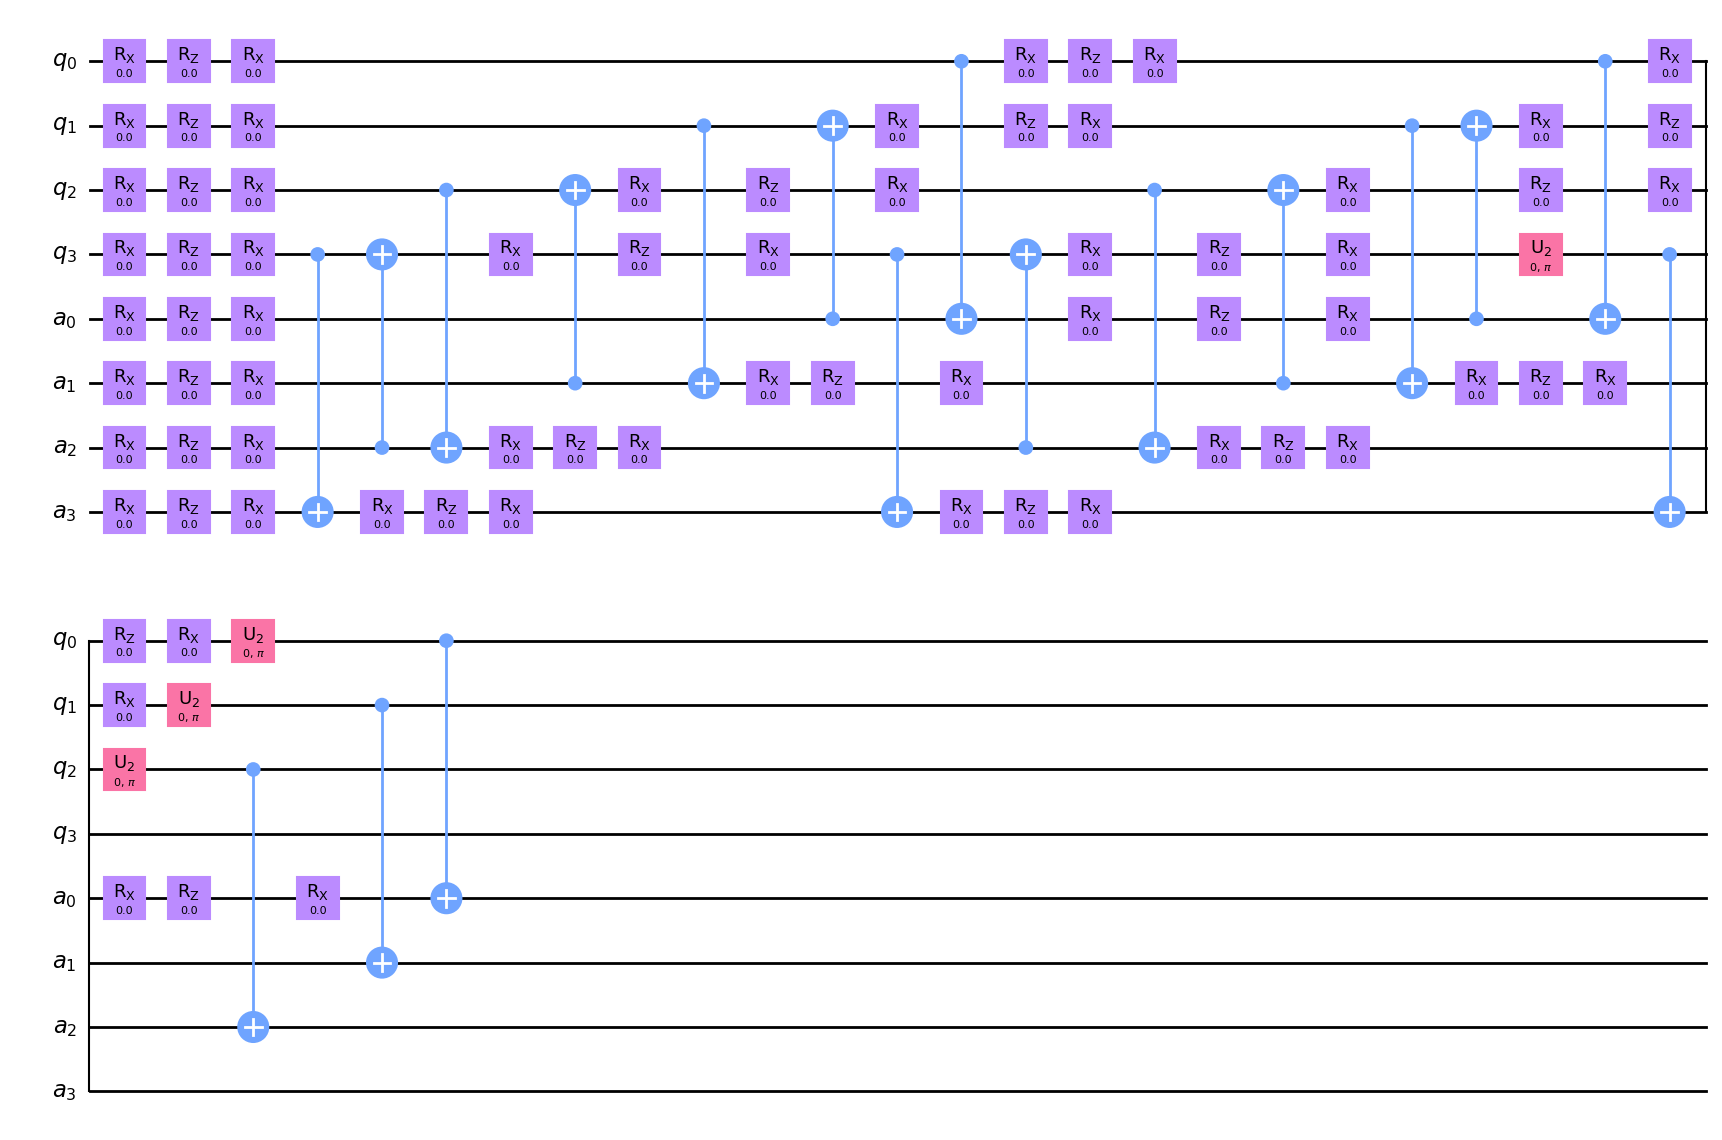

In [7]:
result = get_results("../saved_simulations/turbo/allcontrols4isingRZRXRZ")[0]
preparation(result,-1,False).show()
display(result.state_ansatz(-1).draw(output="mpl"))